# Ralph CNOT - All Simulators
- This notebook contains a recreation of the Ralph CNOT gate from https://arxiv.org/abs/quant-ph/0112088 and demonstrates the application of different simulation objects.

In [1]:
import lightworks as lw
from lightworks import emulator, State

import matplotlib.pyplot as plt
import numpy as np
from time import perf_counter

- Encode the gate below, with the following mode structure: [a0, c0, c1, t0, t1, a1], where a, c and t are the ancillary, control and target modes respectively.
- This is a heralded gate, which requires measurements to ensure it works correctly. The input should contain 1 photon in either c0 or c1 and 1 photon in either t0 or t1. The output requires this same criteria and we should also measure 0 photons across modes a0 and a1. This can be included using the add_herald method.

In [2]:
r = 1/3
loss = 0.35
theta = np.arccos(r)
p = np.pi

cnot_circuit = lw.Circuit(6)
to_add = [(3, p/2, 0), (0, theta, 0), (2, theta, p), (4, theta, 0), 
          (3, p/2, 0)]

for m, t, p in to_add:
    cnot_circuit.add_bs(m, loss = loss, reflectivity = 0.5)
    cnot_circuit.add_ps(m+1, t)
    cnot_circuit.add_bs(m, loss = loss, reflectivity = 0.5)
    cnot_circuit.add_ps(m+1, p)
    if m in [3,4,3]:
        cnot_circuit.add_barrier()
        
# Then add required heralds
cnot_circuit.add_herald(0, 0, 0)
cnot_circuit.add_herald(0, 5, 5)

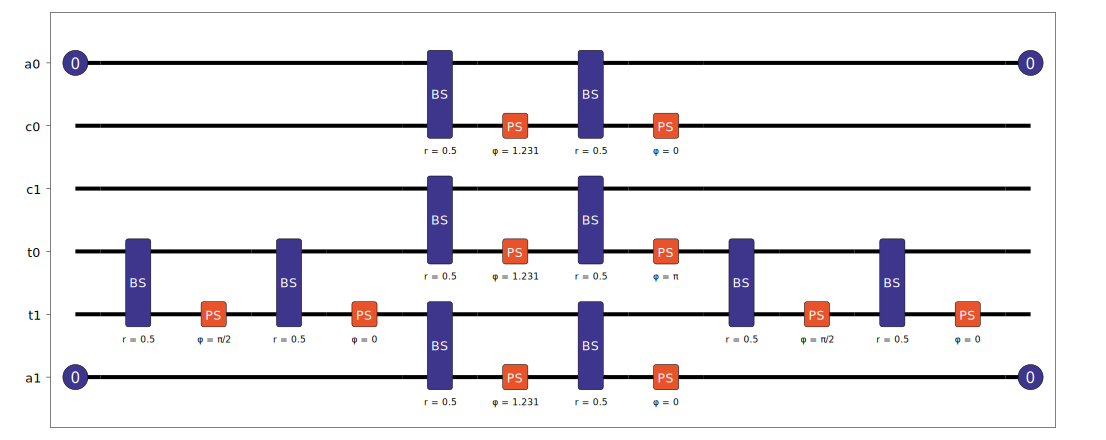

In [3]:
cnot_circuit.display(mode_labels = ["a0", "c0", "c1", "t0", "t1", "a1"])

## Simulator
- First use simulator to directly calculate the probability amplitudes.
- Can simulate all possible inputs without specifying outputs to get all state combinations.

In [4]:
states = [State([1, 0, 1, 0]), State([1, 0, 0, 1]),
          State([0, 1, 1, 0]), State([0, 1, 0, 1])]

sim = emulator.Simulator(cnot_circuit)

results = sim.simulate(states)

- It can be seen that the result is a superposition of many different outputs, the majority of which are not valid according to the usual post-selection rules which would be applied.

In [5]:
results.display_as_dataframe()

,"|2,0,0,0>","|1,1,0,0>","|0,2,0,0>","|1,0,1,0>","|0,1,1,0>","|0,0,2,0>","|1,0,0,1>","|0,1,0,1>","|0,0,1,1>","|0,0,0,2>"
"|1,0,1,0>",0.0+0.0j,-0.236191-0.112803j,0.000000+0.000000j,0.227668-0.080493j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
"|1,0,0,1>",0.0+0.0j,0.236191+0.112803j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,0.227668-0.080493j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j
"|0,1,1,0>",0.0+0.0j,0.000000+0.000000j,0.334024+0.159527j,0.000000+0.000000j,0.000000+0.000000j,-0.135780+0.284301j,0.000000+0.000000j,-0.227668+0.080493j,0.096011-0.201031j,0.000000+0.000000j
"|0,1,0,1>",0.0+0.0j,0.000000+0.000000j,-0.334024-0.159527j,0.000000+0.000000j,-0.227668+0.080493j,0.000000+0.000000j,0.000000+0.000000j,0.000000+0.000000j,-0.096011+0.201031j,0.135780-0.284301j


- Alternatively we can specify the outputs which we know to be valid.

In [6]:
results = sim.simulate(states, states)

- We then get the expected transitions between two qubit states.

In [7]:
results.display_as_dataframe(conv_to_probability = True)

,"|1,0,1,0>","|1,0,0,1>","|0,1,1,0>","|0,1,0,1>"
"|1,0,1,0>",0.058312,0.000000,0.000000,0.000000
"|1,0,0,1>",0.000000,0.058312,0.000000,0.000000
"|0,1,1,0>",0.000000,0.000000,0.000000,0.058312
"|0,1,0,1>",0.000000,0.000000,0.058312,0.000000


## Sampler
- Use the sampler to sample from all possible outputs for one of the possible input states.

In [8]:
sampler = emulator.Sampler(cnot_circuit, State([0,1,1,0]))

results = sampler.sample_N_inputs(10000)

- The output distribution can then be plot to view the number of times each state is measured.

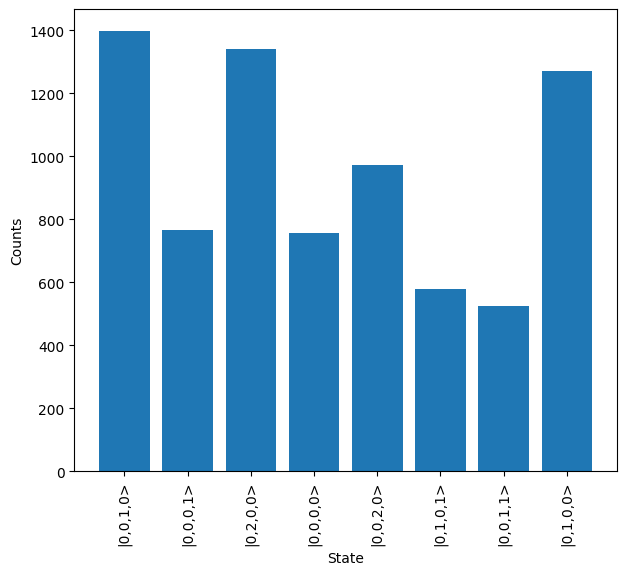

In [9]:
fig, ax = results.plot()

- Can then also apply an imperfect source and detectors.

In [10]:
source = emulator.Source(purity = 0.98, brightness = 0.5, 
                         indistinguishability = 0.94)
detector = emulator.Detector(efficiency = 0.9, p_dark = 1e-5,
                             photon_counting = False)

sampler = emulator.Sampler(cnot_circuit, State([0,1,1,0]), 
                           source = source, detector = detector)

results = sampler.sample_N_inputs(10000)

- This introduces a significant number of additional possible states.

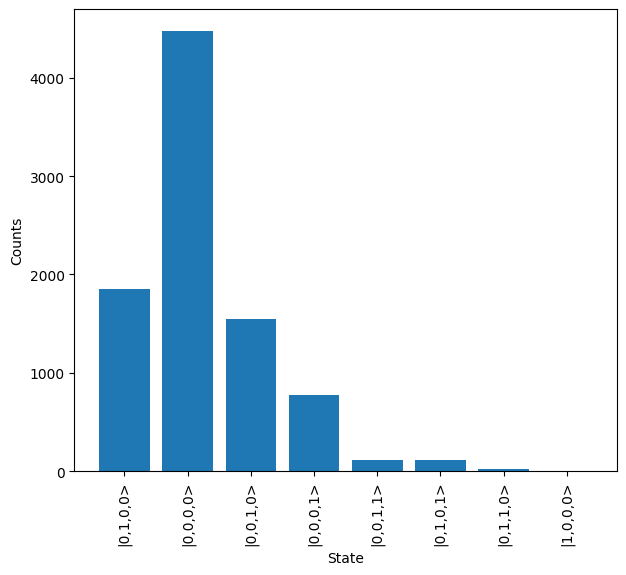

In [11]:
fig, ax = results.plot()

- However we can clean this up by post-selection on the number of photons across the modes.
- We don't need to re-create the sampler object and find the probability distribution for this, and instead just pass the post-selection function to the sample_N_inputs function.

In [12]:
post_select = lambda s: s[0] + s[1] == 1 and s[2] + s[3] == 1

results = sampler.sample_N_inputs(10000, post_select = post_select)

- We can see that this significantly cleans up the output states measured and with the exception of a few erroneous states we see the expected output of |0,0,1,0,1,0>

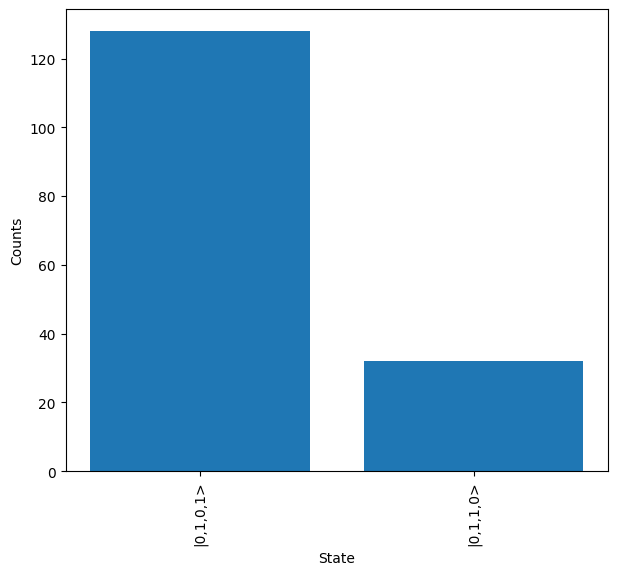

In [13]:
fig, ax = results.plot()

## QuickSampler
- The QuickSampler enables faster sampling from a state in situations where we know photon number should be preserved and do not require imperfect sources or detectors.
- This can be significantly quicker in the cases of larger photon number.
- Below it can be seen that the correct output is produced and the QuickSampler is able to performing the calculation significantly faster.

In [14]:
post_select = lambda s: s[0] + s[1] == 1 and s[2] + s[3] == 1

t0 = perf_counter()
# QuickSampler code
sampler = emulator.QuickSampler(cnot_circuit, State([0,1,0,1]), 
                                photon_counting = False, 
                                post_select = post_select)
results = sampler.sample_N_outputs(10000)

t1 = perf_counter()

print("QuickSampler output", results)

t2 = perf_counter()
# Equivalent code when using normal sampler
detector = emulator.Detector(photon_counting = False)
sampler = emulator.Sampler(cnot_circuit, State([0,1,1,0]),
                           detector = detector)
results = sampler.sample_N_outputs(10000, post_select = post_select, 
                                   min_detection = 2)
t3 = perf_counter()

print(f"QuickSampler time: {t1-t0} seconds")
print(f"Sampler time: {t3-t2} seconds")

QuickSampler output {State(|0,1,1,0>): 10000}
QuickSampler time: 0.023122700047679245 seconds
Sampler time: 0.039802499930374324 seconds


## Analyzer
- The Analyzer will determine all possible outputs under a given set of conditions (such as post-selection and heralding) and return the probability of each.
- First create the analyzer object.

In [15]:
analyzer = emulator.Analyzer(cnot_circuit)

- Then include post-selection of only one photon measured across modes 1/2 and 3/4. 

In [16]:
analyzer.set_post_selection(lambda s: s[0] + s[1] == 1)
analyzer.set_post_selection(lambda s: s[2] + s[3] == 1)

- Then we process each possible input for the circuit, providing the expected transformations between states.
- This is used to calculate an error rate. 
- It is also possible to determine an average performance, which is the defined as the probability that one of the provided outputs is produced for a given input.

In [17]:
inputs = {"00" : State([1,0,1,0]),
          "01" : State([1,0,0,1]),
          "10" : State([0,1,1,0]),
          "11" : State([0,1,0,1])}
states = list(inputs.values())

expected = {inputs["00"] : inputs["00"],
            inputs["01"] : inputs["01"],
            inputs["10"] : inputs["11"],
            inputs["11"] : inputs["10"],}

#analyzer = emulator.Analyzer(cnot_circuit)
results = analyzer.analyze(states, expected = expected)

print(f"Performance = {round(results.performance*100,3)} %")
print(f"Error rate: {round(results.error_rate*100,3)} %")

Performance = 5.831 %
Error rate: 0.0 %


- These results can then also be plotted as a heatmap.

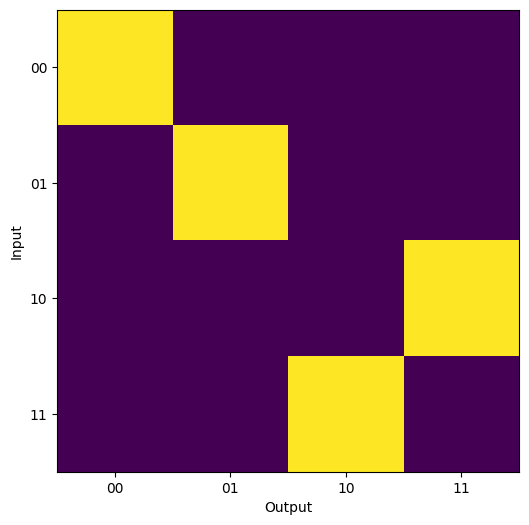

In [18]:
plot_array = np.zeros((len(inputs), len(inputs)))
for i, istate in enumerate(inputs.values()):
    for j, ostate in enumerate(inputs.values()):
        plot_array[i,j] = results[istate,ostate]

in_labels = list(inputs.keys())
out_labels = in_labels

plt.figure(figsize = (7,6))
plt.imshow(plot_array)
plt.xticks(range(len(out_labels)), labels = out_labels)
plt.yticks(range(len(in_labels)), labels = in_labels)
plt.xlabel("Output")
plt.ylabel("Input")
plt.show()